# **TFM - Alessandro Bigolin - Parte 1b: Preprocesamiento**

## **0. Introducción**

NB: En caso de problemas con la visualización del notebook, puedes encontrarlo completamente ejecutado aquí:
https://colab.research.google.com/drive/1vFXYA2zQDcNkqtYL1N_fOCaZdP2bTO-z?usp=sharing

Notebook 1a:
https://colab.research.google.com/drive/1nawLN8tpm6-lxwaZaK8qcN361mtuG3w3?usp=sharing


### **0.1 Un resumen**

En el Notebook 1a, me centré en construir el conjunto de datos principal:

- Realicé *web scraping* en el sitio web de Trenitalia para recopilar todas las estaciones atendidas en Véneto, creando el dataframe **stations_df**.
- Enriquecí esta lista de estaciones con coordenadas geográficas a través de la API de Google Maps y la guardé como un conjunto de datos auxiliar.
- Utilicé la lista de estaciones para filtrar los archivos JSON diarios de TrainStats (enero-mayo de 2025), conservando solo los viajes con al menos una parada en Véneto.
- Combiné todos los archivos diarios filtrados en un único dataframe, **trains_df**, que se guardó como el conjunto de datos principal en formato JSON y CSV.

### **0.2 En este notebook**

1. Comienzo la fase de preprocesamiento verificando la consistencia de los nombres de las estaciones en los dos conjuntos de datos creados en los pasos anteriores: *stations_list_1a.csv* (cargado aquí como **stations_df**) y *trains_data_Veneto_1a.csv* (cargado como **trains_df**). El objetivo principal es asegurar que todas las estaciones listadas en stations_df y presentes en los archivos JSON diarios originales también estén escritas de manera consistente en el conjunto de datos trains_df. Esto garantizará que ninguna estación relevante haya sido omitida o mal etiquetada inadvertidamente durante la adquisición y el filtrado de datos.
2. A continuación, analizaré los tipos de columnas de los dos conjuntos de datos y me aseguraré de que cada columna tenga el tipo de datos apropiado. Luego, verificaré si hay valores faltantes y los manejaré según sea necesario. El dataframe stations_df se exporta como *stations_list_1b.csv*.
3. En el tercer paso, integraré el dataframe trains_df con datos del stations_df limpio, importando específicamente la provincia, latitud y longitud para cada parada de tren en Véneto.
4. Posteriormente, verificaré si hay valores atípicos (outliers) en el conjunto de datos principal trains_df y aplicaré los tratamientos correspondientes.
5. En el paso 5, realizaré ingeniería de características en el conjunto de datos trains_df, convirtiendo algunas variables categóricas en representaciones numéricas mediante codificación one-hot y transformando la información temporal en características numéricas.
6. En la última sección, aplicaré PCA para reducir el conjunto de datos a tres componentes principales y los visualizaré en un gráfico de dispersión 3D interactivo. Luego, analizaré el gráfico para interpretar los patrones detectados.

Finalmente, el dataframe trains_df se exporta como *trains_data_Veneto_1b.csv*.

### **0.3 Importaciones y acceso a Google Drive**

In [1]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import requests
import re
import os
import json
import csv
from datetime import datetime
import pytz
from rapidfuzz import process
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Homogenización de variables categóricas**

Carga de los dos conjuntos de datos:

In [ ]:
stations_csv_path = '/content/drive/MyDrive/Trains_project/stations_list_1a.csv'
trains_csv_path = '/content/drive/MyDrive/Trains_project/trains_data_Veneto_1a.csv'

stations_df = pd.read_csv(stations_csv_path, sep=';')
trains_df = pd.read_csv(trains_csv_path, sep=';')

In [ ]:
stations_df.head()

,station,address,town,province,lat,lon
0,Abano,"Via della Stazione, 10",Abano Terme,PD,45.362136,11.790235
1,Adria,"Via Umberto Maddalena, 32",Adria,RO,45.055549,12.056038
2,Alano-Fener-Valdobbiadene,"Via Stazione, 106",Alano di Piave,BL,45.902645,11.944375
3,Albaredo,"Via Stazione, 60",Vedelago,TV,45.666169,12.012208
4,Altavilla-Tavernelle,"Piazzale Stazione, 35",Altavilla Vicentina,VI,45.511801,11.454374


In [ ]:
trains_df.head()

,day,train_number,category,origin,destination,station,scheduled_arrival,scheduled_departure,arrival_delay,departure_delay
0,01/01/2025,94360,REG,VENEZIA SANTA LUCIA,CONEGLIANO,VENEZIA SANTA LUCIA,0,1735689060,N,1
1,01/01/2025,94360,REG,VENEZIA SANTA LUCIA,CONEGLIANO,VENEZIA PORTO MARGHERA,1735689480,1735689540,n.d.,2
2,01/01/2025,94360,REG,VENEZIA SANTA LUCIA,CONEGLIANO,VENEZIA MESTRE,1735689720,1735689840,1,2
3,01/01/2025,94360,REG,VENEZIA SANTA LUCIA,CONEGLIANO,VENEZIA MESTRE OSPEDALE,1735690320,1735690380,n.d.,1
4,01/01/2025,94360,REG,VENEZIA SANTA LUCIA,CONEGLIANO,MOGLIANO VENETO,1735690620,1735690680,1,58


In [ ]:
# Obtaining the list of unique station names in trains_df
stations_in_data = set(trains_df["station"].unique())
stations_in_data

{'ABANO TERME',
 'ADRIA',
 'ALA',
 'ALANO FENER VALDOBBIADENE',
 'ALASSIO',
 'ALBACINA',
 'ALBAREDO',
 'ALBENGA',
 'ALESSANDRIA',
 'ALTAVILLA TAVERNELLE',
 'ANCONA',
 'ANCONETTA',
 'ANNONE VENETO',
 'AREZZO',
 "ARQUA'",
 'ARQUATA SCRIVIA',
 'ARQUA`',
 'AVIO',
 'BADIA POLESINE',
 'BAIANO DI SPOLETO',
 'BARI CENTRALE',
 'BARICETTA',
 'BARLETTA',
 'BASILIANO',
 'BASSANO DEL GRAPPA',
 'BATTAGLIA TERME',
 'BELLUNO',
 'BEVILACQUA',
 'BISCEGLIE',
 "BIVIO D'AURISINA",
 'BIVIO D`AURISINA',
 'BOLOGNA C.LE',
 'BOLOGNA C.LE/AV',
 'BOLOGNA CENTRALE',
 'BOLOGNA CORTICELLA',
 'BOLOGNA S.RUFFILLO',
 'BOLZANO',
 'BONFERRARO',
 'BORGHETTO',
 "BORGHETTO SULL'ADIGE",
 'BORGO VALSUGANA CENTRO',
 'BORGO VALSUGANA EST',
 'BOSCHI S.ANNA',
 'BOVOLONE',
 'BRENNERO',
 'BRESCIA',
 'BRESCIA FASCIO MERCI',
 'BRESSANONE',
 'BRINDISI',
 'BRONZOLO',
 'BUSA DI VIGONZA',
 'BUTTAPIETRA',
 'BUTTRIO',
 'CALALZO PIEVE CADORE CORTINA',
 'CALCERANICA',
 'CALDERARA-BARGELLINO',
 'CALDIERO',
 'CALDONAZZO',
 'CALLIANO',
 'CAMPO 

De la lista, es evidente que muchas estaciones aparecen con variaciones en sus nombres. El primer paso es, por lo tanto, asegurar la consistencia en la nomenclatura de las estaciones. Para lograr esto, creo un *fuzzy matching* que tiene como objetivo estandarizar los nombres de las estaciones dentro de los conjuntos de datos stations_df y trains_df:

In [ ]:
# Function to regularize punctuation and other text mismatches
def normalize_station_name(text):
    if pd.isnull(text):
        return text
    text = str(text).upper().strip()
    text = re.sub(r"[`´’‘]", "'", text)        # uniform apostrophs
    text = re.sub(r"\s+", " ", text)           # rimoving multiple spaces
    text = re.sub(r"\bSAN\s+", "S.", text)     # SAN -> S.
    text = re.sub(r"\bS\.\s+", "S.", text)     # 'S. ' (with space) -> S.
    text = text.replace("-", " ")              # dash -> space
    text = re.sub(r"\s+", " ", text)           # regularize spaces
    return text.strip()

# Regularizing stations names in stations_df and taking those as reference
stations_df["station"] = stations_df["station"].dropna().apply(normalize_station_name)
reference_stations = stations_df["station"].unique()

# Regularizing stations names in trains_df
columns_to_normalize = ["station", "origin", "destination"]
for col in columns_to_normalize:
    trains_df[col] = trains_df[col].apply(normalize_station_name)

# Function to obtain fuzzy matching between the two dataset
def build_match_map(values_to_check, reference_values, threshold=92):
    match_map = {}
    for val in values_to_check:
        match, score, _ = process.extractOne(val, reference_values)
        if score >= threshold:
            match_map[val] = match
    return match_map

# Applying fuzzy matching to trains_df based on the stations names in stations_df
for col in columns_to_normalize:
    unique_vals = trains_df[col].dropna().unique()
    unmatched = set(unique_vals) - set(reference_stations)
    match_map = build_match_map(unmatched, reference_stations)
    trains_df[col] = trains_df[col].apply(lambda x: match_map.get(x, x))

Verificando los nombres de las estaciones en el conjunto de datos trains_df después de la regularización:

In [ ]:
stations_in_data = set(trains_df["station"].unique())
stations_in_data

{'ABANO TERME',
 'ADRIA',
 'ALA',
 'ALANO FENER VALDOBBIADENE',
 'ALASSIO',
 'ALBACINA',
 'ALBAREDO',
 'ALBENGA',
 'ALESSANDRIA',
 'ALTAVILLA TAVERNELLE',
 'ANCONA',
 'ANCONETTA',
 'ANNONE VENETO',
 'AREZZO',
 "ARQUA'",
 'ARQUATA SCRIVIA',
 'AVIO',
 'BADIA POLESINE',
 'BAIANO DI SPOLETO',
 'BARI CENTRALE',
 'BARICETTA',
 'BARLETTA',
 'BASILIANO',
 'BASSANO DEL GRAPPA',
 'BATTAGLIA TERME',
 'BELLUNO',
 'BEVILACQUA',
 'BISCEGLIE',
 "BIVIO D'AURISINA",
 'BOLOGNA C.LE',
 'BOLOGNA C.LE/AV',
 'BOLOGNA CENTRALE',
 'BOLOGNA CORTICELLA',
 'BOLOGNA S.RUFFILLO',
 'BOLZANO',
 'BONFERRARO',
 'BORGHETTO',
 "BORGHETTO SULL'ADIGE",
 'BORGO VALSUGANA CENTRO',
 'BORGO VALSUGANA EST',
 'BOSCHI S.ANNA',
 'BOVOLONE',
 'BRENNERO',
 'BRESCIA',
 'BRESCIA FASCIO MERCI',
 'BRESSANONE',
 'BRINDISI',
 'BRONZOLO',
 'BUSA DI VIGONZA',
 'BUTTAPIETRA',
 'BUTTRIO',
 'CALALZO PIEVE DI CADORE CORTINA',
 'CALCERANICA',
 'CALDERARA BARGELLINO',
 'CALDIERO',
 'CALDONAZZO',
 'CALLIANO',
 'CAMPO DI TRENS',
 'CAMPODARSEGO',
 

Algunos reemplazos en trains_df deberán hacerse manualmente, ya que a veces no es posible determinar de forma automatizada si dos nombres se refieren a dos estaciones diferentes o no. Por ejemplo, MARANO y MARANO VICENTINO son la misma estación, mientras que PAESE y PAESE CASTAGNOLE son dos estaciones diferentes. Hay muchos otros casos similares.

In [ ]:
def replace_station_name(df, old_value, new_value):
    columns = ["station", "origin", "destination"]
    for col in columns:
        df[col] = df[col].replace(old_value, new_value)

replace_station_name(trains_df, "BOLOGNA C.LE", "BOLOGNA CENTRALE")
replace_station_name(trains_df, "BORGHETTO", "BORGHETTO SULL'ADIGE")
replace_station_name(trains_df, "CASTELNUOVO", "CASTELNUOVO DEL GARDA")
replace_station_name(trains_df, "CERVIGNANO A.G.", "CERVIGNANO-AQUILEIA-GRADO")
replace_station_name(trains_df, "CERVIGNANO AQUILEIA GRADO", "CERVIGNANO-AQUILEIA-GRADO")
replace_station_name(trains_df, "CHIUSI C.T.", "CHIUSI-CHIANCIANO TERME")
replace_station_name(trains_df, "CHIUSI CHIANCIANO TERME", "CHIUSI-CHIANCIANO TERME")
replace_station_name(trains_df, "CIVITANOVA MARCHE", "CIVITANOVA MARCHE-MONTEGRANARO")
replace_station_name(trains_df, "CIVITANOVA MARCHE MONTEGRANARO", "CIVITANOVA MARCHE-MONTEGRANARO")
replace_station_name(trains_df, "DESENZANO", "DESENZANO DEL GARDA-SIRMIONE")
replace_station_name(trains_df, "DESENZANO DEL GARDA SIRMIONE", "DESENZANO DEL GARDA-SIRMIONE")
replace_station_name(trains_df, "DOMEGLIARA", "DOMEGLIARA S.AMBROGIO")
replace_station_name(trains_df, "FIRENZE S.M.N.", "FIRENZE SANTA MARIA NOVELLA")
replace_station_name(trains_df, "GENOVA P.PRINCIPE", "GENOVA PIAZZA PRINCIPE")
replace_station_name(trains_df, "LATISANA LIGNANO B.", "LATISANA-LIGNANO-BIBIONE")
replace_station_name(trains_df, "LATISANA LIGNANO BIBIONE", "LATISANA-LIGNANO-BIBIONE")
replace_station_name(trains_df, "MARANO", "MARANO VICENTINO")
replace_station_name(trains_df, "PONTE GARDENA", "PONTE GARDENA-LAION")
replace_station_name(trains_df, "PONTE GARDENA LAION", "PONTE GARDENA-LAION")
replace_station_name(trains_df, "REGGIO DI CALABRIA CENTRALE", "REGGIO CALABRIA CENTRALE")
replace_station_name(trains_df, "RHO FIERA MILANO", "RHO FIERA")
replace_station_name(trains_df, "S.BENEDETTO SAMBRO CAST.PEPOLI", "S.BENEDETTO SAMBRO CASTIGLIONE PEPOLI")
replace_station_name(trains_df, "S.DONA' DI PIAVE", "S.DONA' DI PIAVE-JESOLO")
replace_station_name(trains_df, "S.DONA' DI PIAVE JESOLO", "S.DONA' DI PIAVE-JESOLO")
replace_station_name(trains_df, "S.FELICE SP", "S.FELICE SUL PANARO")
replace_station_name(trains_df, "S.GIORGIO P.", "S.GIORGIO DI PIANO")
replace_station_name(trains_df, "SERRAVALLE", "SERRAVALLE ALL'ADIGE")
replace_station_name(trains_df, "SISTIANA", "SISTIANA-VISOGLIANO")
replace_station_name(trains_df, "SISTIANA VISOGLIANO", "SISTIANA-VISOGLIANO")
replace_station_name(trains_df, "TERME EUGANEE ABANO MONTEGR.", "TERME EUGANEE ABANO MONTEGROTTO")
replace_station_name(trains_df, "TORINO P.NUOVA", "TORINO PORTA NUOVA")
replace_station_name(trains_df, "TREVISO", "TREVISO CENTRALE")
replace_station_name(trains_df, "VENEZIA S.LUCIA", "VENEZIA SANTA LUCIA")
replace_station_name(trains_df, "VIBO VALENZIA PIZZO", "VIBO VALENTIA-PIZZO")
replace_station_name(trains_df, "VIBO VALENTIA PIZZO", "VIBO VALENTIA-PIZZO")
replace_station_name(trains_df, "VIPITENO", "VIPITENO-VAL DI VIZZE")
replace_station_name(trains_df, "VIPITENO VAL DI VIZZE", "VIPITENO-VAL DI VIZZE")

Ahora, los nombres de las estaciones en trains_df han sido completamente estandarizados. El siguiente paso es asegurarse de que se aplique el mismo estándar a stations_df, para que los nombres puedan compararse correctamente entre los dos conjuntos de datos. Por lo tanto, estandarizo los nombres de las estaciones en stations_df basándome en las convenciones de nomenclatura adoptadas en trains_df:

In [ ]:
def replace_station_name_stations_list(df, old_value, new_value):
    column = ["station"]
    df[column] = df[column].replace(old_value, new_value)

replace_station_name_stations_list(stations_df, "ABANO", "ABANO TERME")
replace_station_name_stations_list(stations_df, "DOLCE'", "POSTO COMUNICAZIONE DOLCE'")
replace_station_name_stations_list(stations_df, "GAGGIO", "GAGGIO PORTA EST")
replace_station_name_stations_list(stations_df, "MARANO", "MARANO VICENTINO")
replace_station_name_stations_list(stations_df, "OSPEDALETTO", "OSPEDALETTO EUGANEO")
replace_station_name_stations_list(stations_df, "S.DONA' DI PIAVE JESOLO", "S.DONA' DI PIAVE-JESOLO")
replace_station_name_stations_list(stations_df, "TREVISO", "TREVISO CENTRALE")
replace_station_name_stations_list(stations_df, "VENEZIA S.LUCIA", "VENEZIA SANTA LUCIA")

Ahora podemos verificar cuántas diferencias quedan entre los nombres de las estaciones en stations_df y los de trains_df. De esta manera, podemos detectar cualquier estación de Véneto que falte en trains_df:

In [ ]:
# Extracting the unique stations from both datasets
stations_in_data = set(trains_df["station"].unique())
stations_from_list = set(stations_df["station"].dropna().str.upper().unique())

# Finding stations that are in stations_df but not in trains_df
not_in_data = stations_from_list - stations_in_data

# Finding stations that are in trains_df
present_in_data = stations_from_list & stations_in_data

# Printing summaries
print(f"Stations from list: {len(stations_from_list)}")
print(f"Present in dataset: {len(present_in_data)}")
print(f"Not in dataset:     {len(not_in_data)}")
for station in sorted(not_in_data):
    print(station)

Stations from list: 164
Present in dataset: 151
Not in dataset:     13
BUSCHE LENTIAI MEL
CAVANELLA D'ADIGE
CHIOGGIA
FAE' FORTOGNA
LEVADA
LOREO
OSPITALE DI CADORE
PONTE DI BRENTA
RONCANOVA
ROSOLINA
S.ANNA DI CHIOGGIA
S.GIUSTINA CESIO
SEDICO BRIBANO


Una mirada a ViaggiaTreno (el sitio web oficial de Trenitalia para la circulación de trenes en tiempo real; véase http://www.viaggiatreno.it/infomobilita/index.jsp) muestra que las 13 estaciones de Véneto que no están en trains_df no estaban operativas durante el período considerado (enero-mayo de 2025) o estaban cerradas indefinidamente.

## **2. Tipos de columnas y tratamiento de valores faltantes**

### **2.1 Tipos de columnas**

Para empezar, examino ambos conjuntos de datos para verificar los tipos de sus columnas, asegurándome de que a cada columna se le asigne el tipo de datos apropiado. Comenzaré con stations_df.

**Tipos de columnas en stations_df:**

In [ ]:
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   station   164 non-null    object 
 1   address   161 non-null    object 
 2   town      164 non-null    object 
 3   province  164 non-null    object 
 4   lat       164 non-null    float64
 5   lon       164 non-null    float64
dtypes: float64(2), object(4)
memory usage: 7.8+ KB


Dado que no utilizaré este conjunto de datos para entrenar modelos de ML, sino únicamente para integrar columnas seleccionadas en trains_df, trataré las columnas `station` y `town` como tipo string para los propósitos actuales de identificación de valores faltantes. La columna `province`, en cambio, se convierte a categoría, ya que posteriormente utilizaré esa columna, junto con las columnas `lat` y `lon`, para ampliar el conjunto de datos `trains_df`.

In [ ]:
stations_df['station'] = stations_df['station'].astype('string')
stations_df['address'] = stations_df['address'].astype('string')
stations_df['town'] = stations_df['town'].astype('string')
stations_df['province'] = stations_df['province'].astype('category')

In [ ]:
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   station   164 non-null    string  
 1   address   161 non-null    string  
 2   town      164 non-null    string  
 3   province  164 non-null    category
 4   lat       164 non-null    float64 
 5   lon       164 non-null    float64 
dtypes: category(1), float64(2), string(3)
memory usage: 7.0 KB


**Tipos de columnas en trains_df:**

In [ ]:
trains_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1478785 entries, 0 to 1478784
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   day                  1478785 non-null  object
 1   train_number         1478785 non-null  int64 
 2   category             1346186 non-null  object
 3   origin               1478785 non-null  object
 4   destination          1478785 non-null  object
 5   station              1478785 non-null  object
 6   scheduled_arrival    1478785 non-null  int64 
 7   scheduled_departure  1478785 non-null  int64 
 8   arrival_delay        1478785 non-null  object
 9   departure_delay      1478785 non-null  object
dtypes: int64(3), object(7)
memory usage: 112.8+ MB


In [ ]:
# Converting day column as type datetime
trains_df['day'] = pd.to_datetime(trains_df['day'], format='%d/%m/%Y', errors='coerce')

# Converting train_number, category, origin, destination, and station columns as type category
cat_cols = ['train_number', 'category', 'origin', 'destination', 'station']
for col in cat_cols:
    trains_df[col] = trains_df[col].astype('category')

# Converting arrival_delay and departure_delay columns to numeric, replacing 'n.d.' with NaN
trains_df['arrival_delay'] = pd.to_numeric(trains_df['arrival_delay'].replace('n.d.', np.nan), errors='coerce')
trains_df['departure_delay'] = pd.to_numeric(trains_df['departure_delay'].replace('n.d.', np.nan), errors='coerce')

Convierto la columna `day` a datetime64 para permitir operaciones temporales (como la extracción de días de la semana), coercionando las fechas inválidas a NaT para la detección de valores faltantes. Luego, convierto las columnas `category`, `origin`, `destination` y `station` a tipo categoría, para reflejar su naturaleza categórica repetida y facilitar agrupamientos o codificaciones posteriores. Las columnas `arrival_delay` y `departure_delay` se convierten a numérico, reemplazando "n.d." por NaN para que los valores faltantes se identifiquen correctamente y las columnas queden listas para análisis cuantitativo. Finalmente, dejo las columnas `scheduled_arrival` y `scheduled_departure` como timestamps Unix (tipo int) por ahora, ya que se derivarán características temporales adicionales en un paso posterior.

In [ ]:
trains_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1478785 entries, 0 to 1478784
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   day                  1478785 non-null  datetime64[ns]
 1   train_number         1478785 non-null  category      
 2   category             1346186 non-null  category      
 3   origin               1478785 non-null  category      
 4   destination          1478785 non-null  category      
 5   station              1478785 non-null  category      
 6   scheduled_arrival    1478785 non-null  int64         
 7   scheduled_departure  1478785 non-null  int64         
 8   arrival_delay        1027325 non-null  float64       
 9   departure_delay      1271825 non-null  float64       
dtypes: category(5), datetime64[ns](1), float64(2), int64(2)
memory usage: 67.8 MB


### **2.2 Tratamiento de valores nulos**

Ahora podemos echar un vistazo a los valores nulos en cada conjunto de datos, comenzando con stations_df.

**Valores nulos en stations_df:**

In [ ]:
print("Missing values in stations_df per column:")
stations_df.isna().sum()

Missing values in stations_df per column:


,0
station,0
address,3
town,0
province,0
lat,0
lon,0


stations_df contiene solo tres valores faltantes, todos en la columna `address`. Identifiquemos a qué estaciones corresponden:

In [ ]:
missing_address = stations_df[stations_df['address'].isna() | (stations_df['address'] == "")]

missing_address

,station,address,town,province,lat,lon
131,S.TROVASO,<NA>,Preganziol,TV,45.625894,12.232566
139,SPINEA,<NA>,Spinea,VE,45.492435,12.162545
152,VENEZIA MESTRE OSPEDALE,<NA>,Venezia,VE,45.513301,12.225561


Después de buscar manualmente las direcciones completas de estas estaciones en línea, puedo ingresarlas directamente en el conjunto de datos. En particular, la estación S. Trovaso no tiene número cívico, y la estación Venezia Mestre Ospedale carece tanto de nombre de calle como de número cívico; en consecuencia, su valor de dirección permanecerá faltante. Es importante destacar que una verificación manual de las coordenadas de estas estaciones confirma que los valores de latitud y longitud son aceptables, por lo que no es necesario realizar ajustes en las columnas lat y lon.

El conjunto de datos `stations_df` no se utilizará para ciencia de datos ni para modelos de machine learning en los pasos siguientes, sino únicamente para integrar información adicional en `trains_df`, que servirá como conjunto de datos principal y único. Por lo tanto, añadir los valores faltantes en la columna `address` no es estrictamente necesario; realizo este paso únicamente para mantener un conjunto de datos más limpio, en caso de que pueda resultar útil para proyectos futuros.

In [ ]:
stations_df.loc[stations_df['station'] == 'S.TROVASO', 'address'] = 'Via San Trovaso'
stations_df.loc[stations_df['station'] == 'SPINEA', 'address'] = ' Via 11 Settembre 2001'

# Check that the missing values are gone
stations_df[stations_df['address'].isna() | (stations_df['address'] == "")]

,station,address,town,province,lat,lon
152,VENEZIA MESTRE OSPEDALE,<NA>,Venezia,VE,45.513301,12.225561


Como no tengo planeado realizar más modificaciones en stations_df, ahora lo guardaré como un nuevo archivo CSV *stations_list_1b.csv*.

In [ ]:
stations_df.to_csv("/content/drive/MyDrive/Trains_project/stations_list_1b.csv", sep=";", index=False)

**Valores nulos en trains_df:**

In [ ]:
print("Missing values in trains_df per column:")
trains_df.isna().sum()

Missing values in trains_df per column:


,0
day,0
train_number,0
category,132599
origin,0
destination,0
station,0
scheduled_arrival,0
scheduled_departure,0
arrival_delay,451460
departure_delay,206960


Como podemos ver, el conjunto de datos trains_df tiene valores faltantes en tres columnas: `category`, `arrival_delay` y `departure_delay`. Comenzaré examinando la columna `category` (que especifica el tipo de servicio proporcionado por el tren; por ejemplo, regional, expreso, etc.), aislando sus valores faltantes.

In [ ]:
missing_category_all = trains_df[trains_df['category'].isna() | (trains_df['category'] == "")]
missing_category_all

,day,train_number,category,origin,destination,station,scheduled_arrival,scheduled_departure,arrival_delay,departure_delay
203,2025-01-01,8505,NaN,BOLZANO,ROMA TERMINI,BOLZANO,0,1735704720,NaN,1.0
204,2025-01-01,8505,NaN,BOLZANO,ROMA TERMINI,TRENTO,1735706460,1735706580,0.0,2.0
205,2025-01-01,8505,NaN,BOLZANO,ROMA TERMINI,ROVERETO,1735707300,1735707420,2.0,2.0
206,2025-01-01,8505,NaN,BOLZANO,ROMA TERMINI,VERONA PORTA NUOVA,1735710000,1735710720,-3.0,1.0
207,2025-01-01,8505,NaN,BOLZANO,ROMA TERMINI,BOLOGNA C.LE/AV,1735713840,1735714020,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1478018,2025-05-31,9437,NaN,VENEZIA SANTA LUCIA,ROMA TERMINI,FERRARA,1748716020,1748716140,22.0,26.0
1478019,2025-05-31,9437,NaN,VENEZIA SANTA LUCIA,ROMA TERMINI,BOLOGNA C.LE/AV,1748717940,1748718120,21.0,22.0
1478020,2025-05-31,9437,NaN,VENEZIA SANTA LUCIA,ROMA TERMINI,FIRENZE SANTA MARIA NOVELLA,1748720340,1748720880,13.0,11.0
1478021,2025-05-31,9437,NaN,VENEZIA SANTA LUCIA,ROMA TERMINI,ROMA TIBURTINA,1748726040,1748726220,8.0,7.0


Primero verificaré cuántos viajes únicos tienen una categoría faltante y examinaré sus números de tren, para ver si surge algún patrón regular en los números que podría ayudar a atribuirles una categoría.

In [ ]:
missing_train_numbers = missing_category_all['train_number'].unique()
len(missing_train_numbers), missing_train_numbers

(112,
 [8505, 9401, 9400, 9700, 8513, ..., 35443, 35281, 1368, 35205, 35487]
 Length: 112
 Categories (1335, int64): [32, 33, 41, 46, ..., 99124, 99125, 99134, 99135])

Del array anterior, de hecho, podemos observar algunos patrones. La gran mayoría de los trenes sin categoría tienen un número de tren de cuatro dígitos, que comienza con 8 o 9. Los trenes restantes tienen números de cinco dígitos, la mayoría de los cuales comienzan con 35.

Ahora, examino el número de categorías únicas presentes en el conjunto de datos y sus valores específicos:

In [ ]:
unique_categories = trains_df['category'].dropna().unique()
n_unique_categories = len(unique_categories)

print(f"Number of unique categories: {n_unique_categories}")
print(f"Categories: {list(unique_categories)}")

Number of unique categories: 8
Categories: ['REG', 'EN', 'IC', 'EC', 'ICN', 'NCL', 'IR', 'EXP']


Ahora verifico si los trenes con una categoría válida muestran patrones regulares en sus números de tren, basados en la longitud del número y en los dos primeros dígitos (prefijo), y presento una tabla cruzada de prefijo x longitud x categoría con porcentajes normalizados

In [ ]:
# Creating helper columns
trains_df['train_number_str'] = trains_df['train_number'].astype(str)
trains_df['prefix'] = trains_df['train_number_str'].str[:2]  # first 2 digits
trains_df['num_length'] = trains_df['train_number_str'].str.len()

# Filtering only rows where the category is known
known_cats = trains_df.dropna(subset=['category'])

# Building cross-tab of prefix × length × category (normalized percentages)
matrix = (
    known_cats
    .groupby(['prefix', 'num_length'])['category']
    .value_counts(normalize=True)
    .rename('percentage')
    .reset_index()
)

matrix

,prefix,num_length,category,percentage
0,11,2,EC,0.0
1,11,2,EN,0.0
2,11,2,EXP,0.0
3,11,2,IC,0.0
4,11,2,ICN,0.0
...,...,...,...,...
1435,99,5,EXP,0.0
1436,99,5,ICN,0.0
1437,99,5,IR,0.0
1438,99,5,NCL,0.0


Basándonos en la tabla cruzada de prefijo y longitud del número frente a categoría, podemos identificar asociaciones fuertes entre ciertas formas de números de tren y sus categorías. Ahora construiré un mapeo para combinaciones donde una sola categoría ocurre con más del 95% de frecuencia. Se elige el umbral del 95% como un compromiso entre maximizar la cobertura de los valores faltantes y garantizar la fiabilidad de la imputación. Este mapeo se utilizará posteriormente para imputar los valores faltantes de categoría para los trenes con el mismo prefijo y longitud de número.

La matriz combinada que se muestra a continuación muestra, para cada combinación de prefijo y longitud del número de tren, la categoría dominante junto con el porcentaje de trenes con esa combinación en esa categoría. Por ejemplo, una celda que muestra EC (100%) indica que todos los trenes con esa combinación de prefijo-longitud se clasifican como EC. Esta representación facilita la identificación de asociaciones fuertes y proporciona una base sólida para imputar valores faltantes de categoría basados en patrones de números de tren.

In [ ]:
# Building mapping for associations >95%
mapping = {}
for (prefix, length), group in matrix.groupby(['prefix', 'num_length']):
    top_cat = group.loc[group['percentage'].idxmax()]
    if top_cat['percentage'] > 0.95:
        mapping[(prefix, length)] = top_cat['category']

# For each prefix-length combination, get the category with the highest percentage
dominant = matrix.loc[matrix.groupby(['prefix', 'num_length'])['percentage'].idxmax()]

# Pivoting the dominant category into a table
dominant_category_matrix = dominant.pivot(index='prefix', columns='num_length', values='category')

# Pivoting the percentages into a separate table
dominant_percentage_matrix = dominant.pivot(index='prefix', columns='num_length', values='percentage')

# Helper function to combine category and percentage
def format_cell(cat, pct):
    if pct == 0:
        return "0%"  # show only 0% without category
    return f"{cat} ({pct*100:.1f}%)"

# Applying the function cell-wise
combined_matrix = dominant_category_matrix.copy().astype(str)
for col in combined_matrix.columns:
    combined_matrix[col] = [
        format_cell(cat, pct)
        for cat, pct in zip(dominant_category_matrix[col], dominant_percentage_matrix[col])
    ]

combined_matrix.fillna("0%", inplace=True)
combined_matrix

num_length,2,3,4,5
prefix,,,,
11,0%,EC (100.0%),0%,0%
12,0%,0%,EC (100.0%),0%
13,0%,0%,EXP (100.0%),EXP (100.0%)
14,0%,EC (100.0%),0%,EXP (100.0%)
15,0%,0%,IC (100.0%),0%
16,0%,0%,0%,REG (100.0%)
17,0%,0%,0%,REG (100.0%)
18,0%,0%,0%,REG (100.0%)
22,0%,0%,0%,REG (100.0%)


La siguiente matriz muestra, para cada combinación de prefijo y longitud del número de tren, el porcentaje de trenes que pertenecen a cada categoría. Cada fila corresponde a una combinación de prefijo-longitud, y cada columna representa una categoría, lo que nos permite ver la distribución de categorías dentro de cada combinación.

In [ ]:
full_matrix = matrix.pivot_table(
    index=['prefix', 'num_length'],
    columns='category',
    values='percentage',
    fill_value=0
)

full_matrix_pct = (full_matrix * 100).round(1)

full_matrix_pct

/tmp/ipython-input-187586684.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  full_matrix = matrix.pivot_table(


category              EC   EN  EXP     IC  ICN   IR   NCL   REG
prefix num_length                                              
11     2             0.0  0.0  0.0    0.0  0.0  0.0   0.0   0.0
       3           100.0  0.0  0.0    0.0  0.0  0.0   0.0   0.0
       4             0.0  0.0  0.0    0.0  0.0  0.0   0.0   0.0
       5             0.0  0.0  0.0    0.0  0.0  0.0   0.0   0.0
12     2             0.0  0.0  0.0    0.0  0.0  0.0   0.0   0.0
...                  ...  ...  ...    ...  ...  ...   ...   ...
98     5             0.0  0.0  0.0    0.0  0.0  0.0  69.6  30.4
99     2             0.0  0.0  0.0    0.0  0.0  0.0   0.0   0.0
       3             0.0  0.0  0.0    0.0  0.0  0.0   0.0   0.0
       4             0.0  0.0  0.0    0.0  0.0  0.0   0.0   0.0
       5             0.0  0.0  0.0  100.0  0.0  0.0   0.0   0.0

[180 rows x 8 columns]

Ahora podemos rellenar los valores faltantes de la categoría buscando el prefijo y la longitud del número de cada tren en el diccionario de mapeo. Si existe una asociación fuerte (>0.95), se asigna la categoría correspondiente; de lo contrario, el valor faltante permanece como NaN.

In [ ]:
def impute_category(row, mapping):
    if pd.isna(row['category']):
        key = (row['prefix'], row['num_length'])
        return mapping.get(key, np.nan)
    return row['category']

trains_df['category'] = trains_df.apply(lambda r: impute_category(r, mapping), axis=1)

In [ ]:
trains_df.isna().sum()

,0
day,0
train_number,0
category,132591
origin,0
destination,0
station,0
scheduled_arrival,0
scheduled_departure,0
arrival_delay,451460
departure_delay,206960


Desafortunadamente, la función de imputación solo redujo el número total de valores faltantes en la columna de categoría en 8 (de 132599 a 132591). Reducir el umbral de mapeo al 85% no mejora esto. Asignaré los valores faltantes restantes a una categoría de marcador de posición, UNK (para 'Desconocido').

Las columnas `train_number_str`, `prefix` y `num_length`, que se crearon para ayudar a imputar valores faltantes de la categoría, ahora se pueden eliminar.

In [ ]:
trains_df.drop(columns=['train_number_str', 'prefix', 'num_length'], inplace=True)

trains_df['category'] = trains_df['category'].fillna('UNK')

trains_df.isna().sum()

,0
day,0
train_number,0
category,0
origin,0
destination,0
station,0
scheduled_arrival,0
scheduled_departure,0
arrival_delay,451460
departure_delay,206960


Por el momento, dejaré los valores faltantes de `arrival_delay` en la primera estación de cada tren y los valores faltantes de `departure_delay` en la primera y última estación de cada tren como están. Por un lado, no hay una forma razonable de calcular los valores faltantes para los retrasos de salida en la primera estación; por otro lado, la primera estación no tiene un retraso de llegada para medir, y la última estación no tiene un retraso de salida.

Luego, imputaré los valores faltantes restantes de `arrival_delay`. Para las estaciones intermedias, calculo el valor faltante como el promedio redondeado del retraso de salida de la estación anterior y el retraso de salida de la estación actual. Para la última estación de cada tren, relleno el valor faltante con el retraso de salida de la penúltima estación.

In [ ]:
def impute_arrival_delay(df):
    # Grouping by train
    grouped = df.groupby(['day', 'train_number'], group_keys=False, observed=False)

    imputed_list = []

    for _, group in grouped:
        arr_delay = group['arrival_delay'].values
        dep_delay = group['departure_delay'].values

        # Forward-filling departure_delay to handle consecutive NaNs
        dep_filled = pd.Series(dep_delay).ffill().values

        n = len(arr_delay)

        # Intermediate stations
        for i in range(1, n-1):
            if np.isnan(arr_delay[i]) and not (np.isnan(dep_filled[i-1]) or np.isnan(dep_filled[i])):
                arr_delay[i] = int(round((dep_filled[i-1] + dep_filled[i]) / 2))

        # Last station
        if np.isnan(arr_delay[-1]) and not np.isnan(dep_filled[-2]):
            arr_delay[-1] = dep_filled[-2]

        group['arrival_delay'] = arr_delay
        imputed_list.append(group)

    return pd.concat(imputed_list, ignore_index=True)

trains_df = impute_arrival_delay(trains_df)

Para los valores faltantes en la columna `departure_delay` en estaciones intermedias, tomaré el promedio entero del retraso de llegada en la estación actual y el retraso de llegada en la siguiente estación.

In [ ]:
def impute_departure_delay(df):
    grouped = df.groupby(['day', 'train_number'], group_keys=False, observed=False)

    imputed_list = []

    for _, group in grouped:
        dep_delay = group['departure_delay'].values
        arr_delay = group['arrival_delay'].values

        n = len(dep_delay)

        # Intermediate stations
        for i in range(1, n-1):
            if np.isnan(dep_delay[i]) and not (np.isnan(arr_delay[i]) or np.isnan(arr_delay[i+1])):
                dep_delay[i] = int(round((arr_delay[i] + arr_delay[i+1]) / 2))

        group['departure_delay'] = dep_delay
        imputed_list.append(group)

    return pd.concat(imputed_list, ignore_index=True)

trains_df = impute_departure_delay(trains_df)

In [ ]:
trains_df.isna().sum()

,0
day,0
train_number,0
category,0
origin,0
destination,0
station,0
scheduled_arrival,0
scheduled_departure,0
arrival_delay,151720
departure_delay,151612


In [ ]:
# Rows with missing arrival_delay
missing_arrival = trains_df[trains_df['arrival_delay'].isna()]

# Rows with missing departure_delay
missing_departure = trains_df[trains_df['departure_delay'].isna()]

# First station of each train
first_stop = trains_df.groupby(['day', 'train_number'], as_index=False, observed=False).head(1)

# Last station of each train
last_stop = trains_df.groupby(['day', 'train_number'], as_index=False, observed=False).tail(1)

# Missing arrival_delay at first station
missing_arrival_first = first_stop[first_stop['arrival_delay'].isna()]
print(f"Missing arrival_delay at first stations: {len(missing_arrival_first)}")

# Missing departure_delay at last station
missing_departure_last = last_stop[last_stop['departure_delay'].isna()]
print(f"Missing departure_delay at last stations: {len(missing_departure_last)}")

# Intermediate stations with missing arrival_delay
missing_arrival_intermediate = missing_arrival[~missing_arrival.index.isin(first_stop.index)]
print(f"Missing arrival_delay at intermediate stations: {len(missing_arrival_intermediate)}")

# Intermediate stations with missing departure_delay
missing_departure_intermediate = missing_departure[~missing_departure.index.isin(last_stop.index)]
print(f"Missing departure_delay at intermediate stations: {len(missing_departure_intermediate)}")

Missing arrival_delay at first stations: 129333
Missing departure_delay at last stations: 129225
Missing arrival_delay at intermediate stations: 22387
Missing departure_delay at intermediate stations: 22387


In [ ]:
missing_arrival_intermediate

,day,train_number,category,origin,destination,station,scheduled_arrival,scheduled_departure,arrival_delay,departure_delay
9184,2025-01-02,3845,REG,VIPITENO-VAL DI VIZZE,BOLOGNA CENTRALE,COLLE ISARCO,1735827570,1735827600,NaN,NaN
9185,2025-01-02,3845,REG,VIPITENO-VAL DI VIZZE,BOLOGNA CENTRALE,VIPITENO-VAL DI VIZZE,0,1735828020,NaN,3.0
10688,2025-01-02,9759,UNK,MILANO CENTRALE,TRIESTE CENTRALE,TORINO PORTA SUSA,1735840080,1735840200,NaN,NaN
10689,2025-01-02,9759,UNK,MILANO CENTRALE,TRIESTE CENTRALE,RHO FIERA,1735842360,1735842480,NaN,NaN
10690,2025-01-02,9759,UNK,MILANO CENTRALE,TRIESTE CENTRALE,MILANO PORTA GARIBALDI,1735843200,1735843380,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1477864,2025-05-31,17142,REG,MANTOVA,VERONA PORTA NUOVA,ROVERBELLA,1748698980,1748699040,NaN,NaN
1477865,2025-05-31,17142,REG,MANTOVA,VERONA PORTA NUOVA,MOZZECANE,1748699400,1748699460,NaN,NaN
1477866,2025-05-31,17142,REG,MANTOVA,VERONA PORTA NUOVA,VILLAFRANCA DI VERONA,1748700000,1748700060,NaN,NaN
1477867,2025-05-31,17142,REG,MANTOVA,VERONA PORTA NUOVA,DOSSOBUONO,1748700360,1748700420,NaN,NaN


Eliminaré las 22.387 entradas de paradas intermedias donde faltan tanto `arrival_delay` como `departure_delay`. Como se puede observar arriba, estos valores faltantes están concentrados en trenes particulares y, dado que no existen valores circundantes para imputarlos, eliminarlos es el enfoque más razonable. Después de este paso, los valores faltantes restantes deberían ser únicamente los legítimos en la primera o última estación de un viaje.

In [ ]:
# Getting train identifiers (day + train_number) for trains with missing intermediate delays
trains_to_drop = pd.concat([
    missing_arrival_intermediate[['day', 'train_number']],
    missing_departure_intermediate[['day', 'train_number']]
]).drop_duplicates()

# Filtering out all rows corresponding to these trains
trains_df = trains_df.merge(
    trains_to_drop.assign(drop_flag=1),
    on=['day', 'train_number'],
    how='left'
)
trains_df = trains_df[trains_df['drop_flag'].isna()].drop(columns='drop_flag')

Una mirada más de cerca al conjunto de datos trains_df revela otro problema con las columnas `scheduled_departure` y `scheduled_arrival`. Estas columnas parecen no contener valores faltantes, pero de hecho deberían: `scheduled_departure` debería ser NaN en la última estación de un viaje, y `scheduled_arrival` debería ser NaN en la primera estación de un viaje. En cambio, estos valores faltantes legítimos están codificados actualmente como 0. Reemplazaré todos los valores 0 en estas columnas por NaN, ya que 0 no puede representar una marca de tiempo aceptable (se almacenan como marcas de tiempo Unix). Me encargaré de estos valores faltantes en un punto posterior.

In [ ]:
trains_df[['scheduled_departure', 'scheduled_arrival']] = trains_df[['scheduled_departure', 'scheduled_arrival']].replace(0, np.nan)
trains_df['scheduled_departure'] = trains_df['scheduled_departure'].astype('Int64')
trains_df['scheduled_arrival'] = trains_df['scheduled_arrival'].astype('Int64')

trains_df.isna().sum()

,0
day,0
train_number,0
category,0
origin,0
destination,0
station,0
scheduled_arrival,126844
scheduled_departure,127359
arrival_delay,126788
departure_delay,126684


## **3. Integración de los dos conjuntos de datos**

Ahora enriqueceré el conjunto de datos trains_df fusionándolo con el conjunto de datos stations_df, mediante *left merge* en la columna `station` para agregar información geográfica para cada estación. Específicamente, incorporaré las columnas `province`, `lat` y `lon`. La columna `province` se incluye porque puede proporcionar información sobre el flujo de tráfico y los retrasos de los trenes en diferentes zonas de la región de Véneto. Las columnas `lat` y `lon` se agregan porque pueden ser útiles para visualizaciones que involucren mapas.

Un problema que surge de esta operación de fusión es que, para las estaciones ubicadas fuera de Véneto, no existe una entrada coincidente en stations_df, por lo que sus valores de `lat`, `lon` y `province` permanecerán faltantes. Para mantener la columna `province` consistente y adecuada para su uso en modelos de aprendizaje automático, reemplazaré los valores faltantes con el marcador de posición "OUTSIDE_VENETO".

In [ ]:
# Left merge of trains_df with stations_df on the station column to add province, lat, and lon columns to trains_df
trains_df = trains_df.merge(
    stations_df[['station', 'province', 'lat', 'lon']],
    on='station',
    how='left'
)

# Replacing missing province (stations outside Veneto) with a placeholder
trains_df['province'] = trains_df['province'].astype('category')
trains_df['province'] = trains_df['province'].cat.add_categories(["OUTSIDE_VENETO"])
trains_df['province'] = trains_df['province'].fillna("OUTSIDE_VENETO")

trains_df.head(2)

,day,train_number,category,origin,destination,station,scheduled_arrival,scheduled_departure,arrival_delay,departure_delay,province,lat,lon
0,2025-01-01,32,EC,VENEZIA SANTA LUCIA,CHIASSO,VENEZIA SANTA LUCIA,<NA>,1735741080,NaN,2.0,VE,45.441070,12.321044
1,2025-01-01,32,EC,VENEZIA SANTA LUCIA,CHIASSO,VENEZIA MESTRE,1735741680,1735741800,3.0,3.0,VE,45.493488,12.246318


## **4. Detección y tratamiento de valores atípicos (outliers)**

En este paso, detectaré y manejaré valores anómalos en las columnas numéricas del conjunto de datos trains_df, centrándome en `arrival_delay`, `departure_delay`, `scheduled_arrival` y `scheduled_departure`. Se eliminarán los valores que sean claramente imposibles, como valores extremadamente negativos, retrasos excesivamente grandes o marcas de tiempo no positivas. Para valores de retraso extremos pero plausibles, se considerará la limitación (capping) en los percentiles 1 y 99 para reducir su impacto mientras se conserva la estructura general de los datos. La limpieza garantizará que el conjunto de datos sea adecuado para entrenar modelos de aprendizaje automático.

Antes de realizar cualquier limpieza, inspeccionaré el conjunto de datos `trains_df` para detectar valores atípicos monovariables y bivariables. Para las columnas numéricas como `arrival_delay`, `departure_delay`, `scheduled_arrival` y `scheduled_departure`, trazaré diagramas de caja (boxplots) e identificaré posibles valores atípicos utilizando la regla 1.5xIQR. Para las columnas categóricas como `category` y `province`, examinaré los recuentos de frecuencia. Además, exploraré las relaciones entre variables numéricas con diagramas de dispersión (scatterplots), las relaciones numérico-categóricas con diagramas de caja y las relaciones entre variables categóricas con tablas cruzadas.

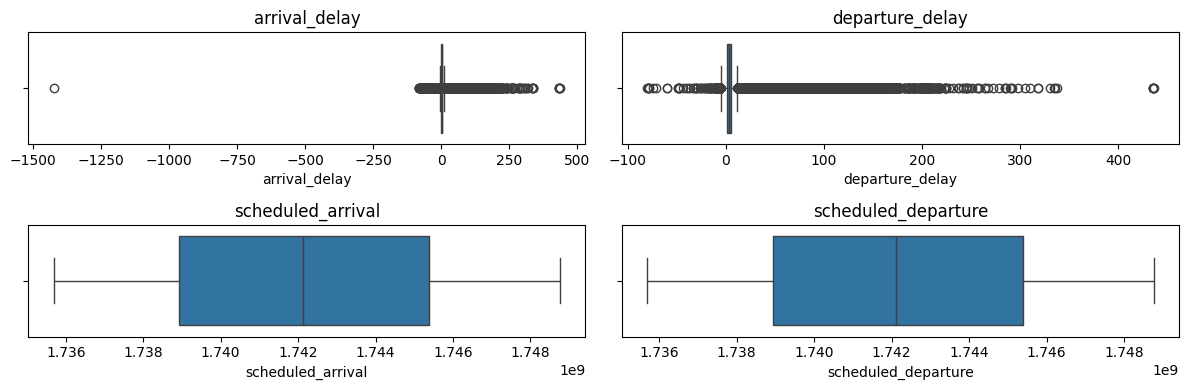

arrival_delay - potential outliers: 109313
departure_delay - potential outliers: 98857
scheduled_arrival - potential outliers: 0
scheduled_departure - potential outliers: 0


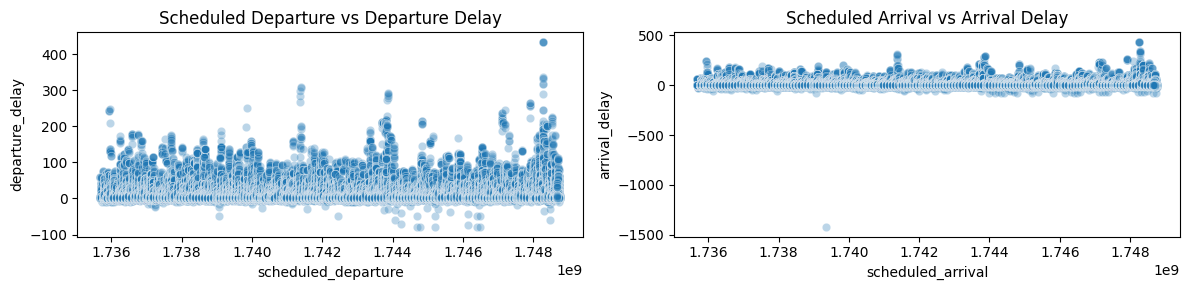

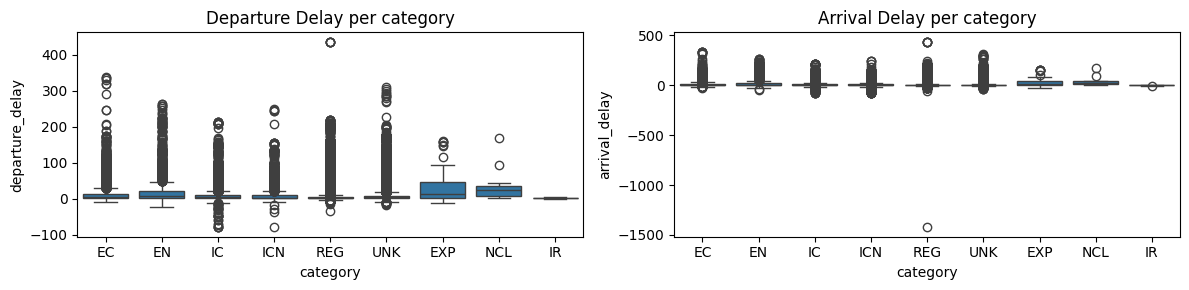

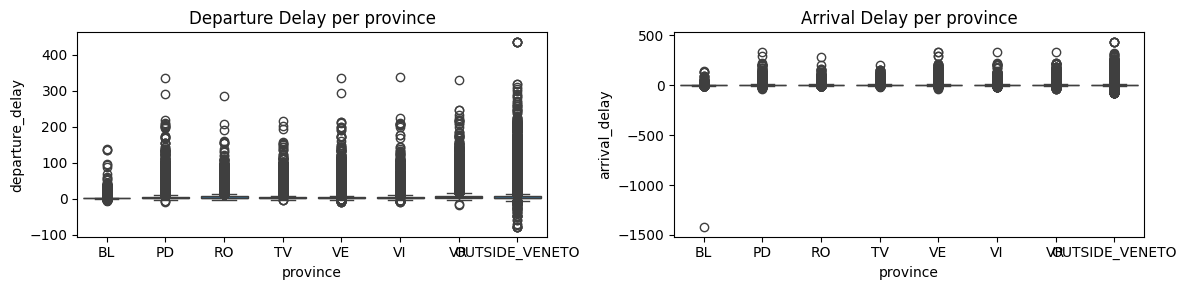

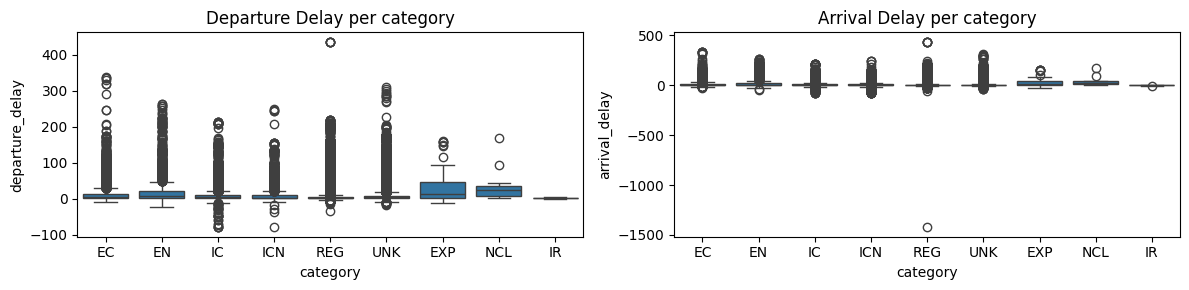

category frequency counts

category
REG    1269062
UNK     130872
IC       22426
EC       16896
ICN       5671
EN        4609
EXP        177
IR          23
NCL         14
Name: count, dtype: int64 

province frequency counts

province
OUTSIDE_VENETO    464121
VE                304883
TV                192481
PD                178813
VR                150202
VI                110885
RO                 35101
BL                 13264
Name: count, dtype: int64 

Cross-tabulation: category vs province

province     BL      PD     RO      TV      VE      VI      VR  OUTSIDE_VENETO
category                                                                      
EC            0    1089      0       0    1961    1083    2495           10268
EN            0     348      0       2       0     265     560            3434
EXP           0       7      0       0      49       7      40              74
IC            0    1284    610     111    1769       5     307           18340
ICN           0     630

In [ ]:
# Numeric columns: boxplots and outlier counts
numeric_cols = ['arrival_delay', 'departure_delay', 'scheduled_arrival', 'scheduled_departure']

plt.figure(figsize=(12,4))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=trains_df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Printing number of potential outliers per numeric column
for col in numeric_cols:
    Q1 = trains_df[col].quantile(0.25)
    Q3 = trains_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = trains_df[(trains_df[col] < Q1 - 1.5*IQR) | (trains_df[col] > Q3 + 1.5*IQR)]
    print(f"{col} - potential outliers: {len(outliers)}")


# Numeric-Numeric relationships: scatterplots
plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
sns.scatterplot(x='scheduled_departure', y='departure_delay', data=trains_df, alpha=0.3)
plt.title("Scheduled Departure vs Departure Delay")

plt.subplot(1,2,2)
sns.scatterplot(x='scheduled_arrival', y='arrival_delay', data=trains_df, alpha=0.3)
plt.title("Scheduled Arrival vs Arrival Delay")

plt.tight_layout()
plt.show()


# Numeric-Categorical relationships: boxplots
categorical_cols = ['category', 'province']

for cat_col in categorical_cols + ['category']:
    plt.figure(figsize=(12,3))

    plt.subplot(1,2,1)
    sns.boxplot(x=cat_col, y='departure_delay', data=trains_df)
    plt.title(f"Departure Delay per {cat_col}")

    plt.subplot(1,2,2)
    sns.boxplot(x=cat_col, y='arrival_delay', data=trains_df)
    plt.title(f"Arrival Delay per {cat_col}")

    plt.tight_layout()
    plt.show()


# Categorical columns: frequency counts
for col in categorical_cols:
    print(f"{col} frequency counts\n")
    print(trains_df[col].value_counts(), "\n")


# Categorical-Categorical relationships: cross-tabulations
all_cat_cols = list(dict.fromkeys(categorical_cols + ['category']))  # avoiding duplicates

for col1, col2 in combinations(all_cat_cols, 2):
    print(f"Cross-tabulation: {col1} vs {col2}\n")
    print(pd.crosstab(trains_df[col1], trains_df[col2]), "\n")

Después de calcular y visualizar los valores atípicos en el conjunto de datos, queda claro que existen valores extremadamente altos o bajos para `arrival_delay` y `departure_delay`. Un posible enfoque es aplicar el capping o Winsorization, por ejemplo, recortando los valores en los percentiles 1 y 99. Probé esto, utilizando el código reproducido a continuación:

```
#for col in ['arrival_delay', 'departure_delay']:
#    lower = trains_df[col].quantile(0.01)
#    upper = trains_df[col].quantile(0.99)
#    trains_df.loc[:, col] = trains_df[col].clip(lower=lower, upper=upper)
```

Sin embargo, al ejecutar este código los valores máximos de `arrival_delay` quedaban comprimidos a solo 34 minutos, lo cual considero que conlleva el riesgo de perder tendencias importantes en los datos:

- En primer lugar, el modelo de IA para predecir retrasos de llegada, que se desarrollará en el Notebook 2, vería únicamente un rango estrecho de valores y podría sobreajustarse a los casos comunes, ignorando retrasos extremos pero plausibles.  
- En segundo lugar, los retrasos elevados suelen contener información importante sobre el comportamiento de los trenes, los efectos de cadenas de estaciones o las características de rutas específicas, y eliminarlos impediría que el modelo aprendiera estas dinámicas.  

Por lo tanto, solo eliminaré las entradas con retrasos superiores a 180 minutos (3 horas), ya que parece, también a partir de los gráficos, que por debajo de este umbral todavía podemos observar tendencias que se vuelven mucho más raras por encima.  

Asimismo, unificaré las categorías de tren IR, NCL y EXP en UNK (*Unknown*). NCL significa Non Clasificado, y las tres representan muy pocos trenes. Mantenerlas como categorías separadas no aportaría información significativa y podría introducir ruido.

In [ ]:
# Removing out-of-scale values (delays that are too negative or too large, negative timestamps)
trains_df = trains_df[
    (trains_df['arrival_delay'].isna() | ((trains_df['arrival_delay'] >= -20) & (trains_df['arrival_delay'] <= 180))) &
    (trains_df['departure_delay'].isna() | ((trains_df['departure_delay'] >= -20) & (trains_df['departure_delay'] <= 180))) &
    (trains_df['scheduled_arrival'].isna() | (trains_df['scheduled_arrival'] > 0)) &
    (trains_df['scheduled_departure'].isna() | (trains_df['scheduled_departure'] > 0))
]

# Merging very rare train categories (IR, NCL, EXP) into UNK
rare_categories = ['IR', 'NCL', 'EXP']
trains_df['category'] = trains_df['category'].apply(lambda x: x if x not in rare_categories else 'UNK')

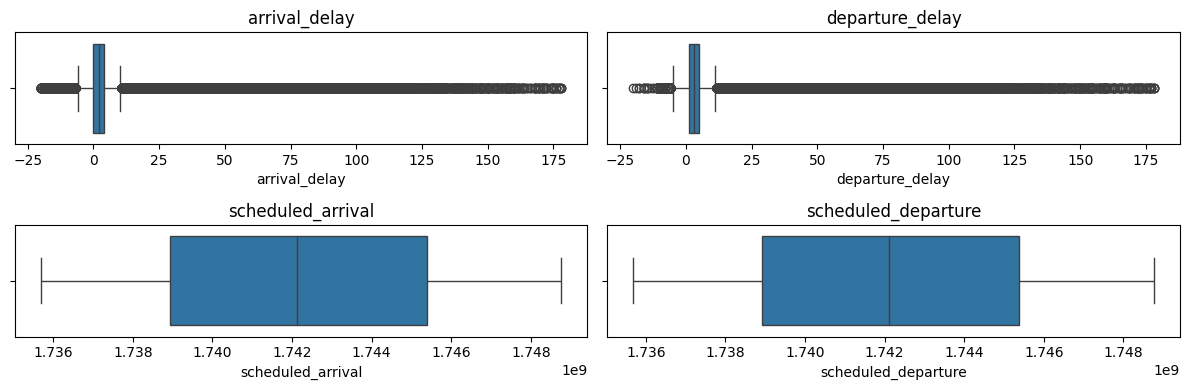

arrival_delay - potential outliers: 108728
departure_delay - potential outliers: 98651
scheduled_arrival - potential outliers: 0
scheduled_departure - potential outliers: 0


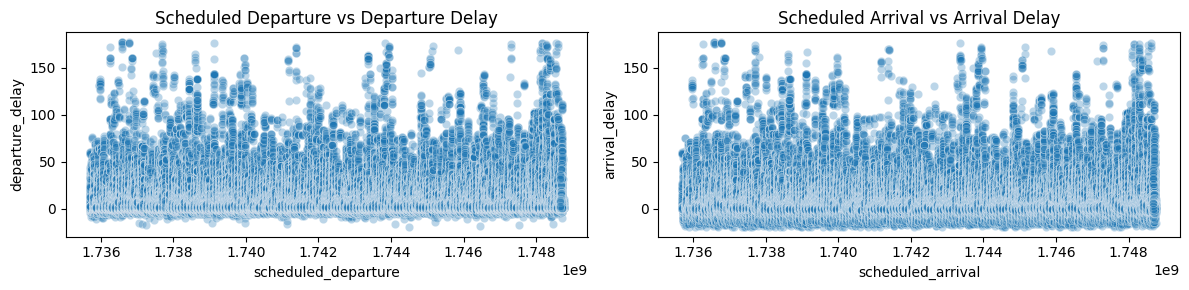

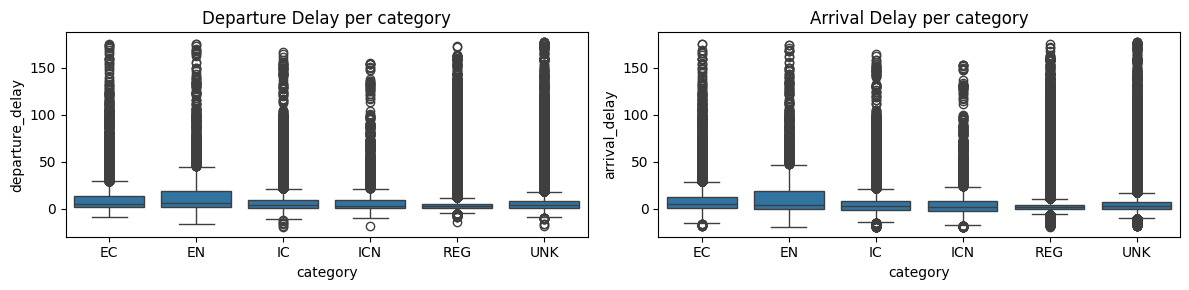

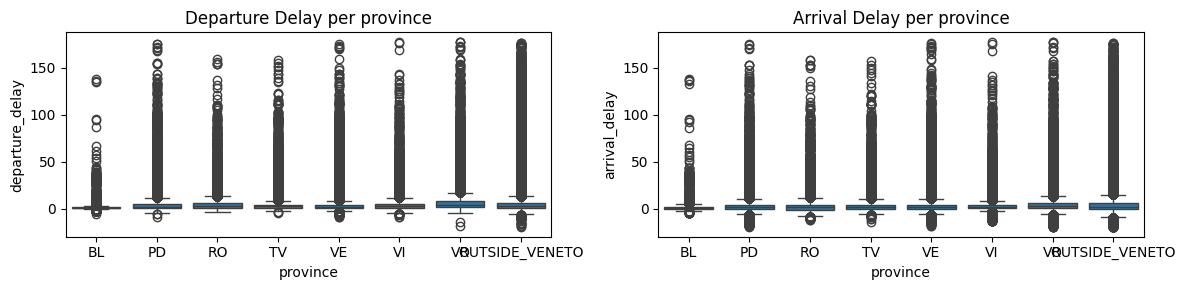

Number of trains per category:

category
REG    1268950
UNK     131045
IC       22299
EC       16877
ICN       5442
EN        4541
Name: count, dtype: int64


In [ ]:
# Numeric columns: boxplots and outlier counts
numeric_cols = ['arrival_delay', 'departure_delay', 'scheduled_arrival', 'scheduled_departure']

plt.figure(figsize=(12,4))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=trains_df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Printing number of potential outliers per numeric column
for col in numeric_cols:
    Q1 = trains_df[col].quantile(0.25)
    Q3 = trains_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = trains_df[(trains_df[col] < Q1 - 1.5*IQR) | (trains_df[col] > Q3 + 1.5*IQR)]
    print(f"{col} - potential outliers: {len(outliers)}")

# Numeric-Numeric relationships: scatterplots
plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
sns.scatterplot(x='scheduled_departure', y='departure_delay', data=trains_df, alpha=0.3)
plt.title("Scheduled Departure vs Departure Delay")

plt.subplot(1,2,2)
sns.scatterplot(x='scheduled_arrival', y='arrival_delay', data=trains_df, alpha=0.3)
plt.title("Scheduled Arrival vs Arrival Delay")

plt.tight_layout()
plt.show()

# Numeric-Categorical relationships: boxplots
categorical_cols = ['category', 'province']

for cat_col in categorical_cols:
    plt.figure(figsize=(12,3))

    plt.subplot(1,2,1)
    sns.boxplot(x=cat_col, y='departure_delay', data=trains_df)
    plt.title(f"Departure Delay per {cat_col}")

    plt.subplot(1,2,2)
    sns.boxplot(x=cat_col, y='arrival_delay', data=trains_df)
    plt.title(f"Arrival Delay per {cat_col}")

    plt.tight_layout()
    plt.show()

# Number of stops per category
print("Number of stops per category:\n")
print(trains_df['category'].value_counts())

## **5. Transformación de datos**

En esta sección, transformo los datos para preparar el conjunto de datos para el entrenamiento de modelos de ML destinados a predecir retrasos de trenes. Primero, extraeré las horas y minutos de las columnas `scheduled_departure` y `scheduled_arrival` y también las transformaré utilizando funciones seno y coseno para capturar la ciclicidad temporal. Luego, extraigo el día de la semana de la columna `day`. Finalmente, transformo las variables categóricas `category` y `province` en múltiples variables numéricas mediante *one-hot encoding*.  

Todas las demás columnas categóricas que se usarán para el entrenamiento también deberían ser codificadas mediante *one-hot encoding*, pero esto incrementaría drásticamente el número de columnas en el conjunto de datos debido a la gran cantidad de valores únicos en esas columnas. Para mantener el conjunto de datos más simple, planeo usar modelos de IA que puedan manejar variables categóricas de manera interna (por ejemplo, LightGBM, CatBoost). Algunas columnas siguen siendo codificadas mediante *one-hot encoding* para cumplir con los requisitos del TFM.

In [ ]:
trains_df = trains_df.copy()

# Converting scheduled timestamps into datetime with Europe/Rome timezone
trains_df.loc[:, 'scheduled_departure_dt'] = pd.to_datetime(
    trains_df['scheduled_departure'], unit='s', utc=True
).dt.tz_convert('Europe/Rome')

trains_df.loc[:, 'scheduled_arrival_dt'] = pd.to_datetime(
    trains_df['scheduled_arrival'], unit='s', utc=True
).dt.tz_convert('Europe/Rome')

# Extracting hours and minutes
trains_df.loc[:, 'scheduled_departure_hour'] = trains_df['scheduled_departure_dt'].dt.hour
trains_df.loc[:, 'scheduled_departure_minute'] = trains_df['scheduled_departure_dt'].dt.minute
trains_df.loc[:, 'scheduled_arrival_hour'] = trains_df['scheduled_arrival_dt'].dt.hour
trains_df.loc[:, 'scheduled_arrival_minute'] = trains_df['scheduled_arrival_dt'].dt.minute

# Encoding cyclical features using sin/cos
for col in ['scheduled_departure_hour', 'scheduled_arrival_hour']:
    trains_df.loc[:, f'{col}_sin'] = np.sin(2 * np.pi * trains_df[col] / 24)
    trains_df.loc[:, f'{col}_cos'] = np.cos(2 * np.pi * trains_df[col] / 24)

for col in ['scheduled_departure_minute', 'scheduled_arrival_minute']:
    trains_df.loc[:, f'{col}_sin'] = np.sin(2 * np.pi * trains_df[col] / 60)
    trains_df.loc[:, f'{col}_cos'] = np.cos(2 * np.pi * trains_df[col] / 60)

# Extracting day of the week
trains_df.loc[:, 'day_of_week'] = trains_df['day'].dt.dayofweek.astype("category")  # (Monday = 0 ... Sunday = 6)

# One-hot encoding category values
category_dummies = pd.get_dummies(trains_df['category'], prefix='category', dummy_na=False)
trains_df = pd.concat([trains_df, category_dummies], axis=1)

# One-hot encoding province values
province_dummies = pd.get_dummies(trains_df['province'], prefix='province', dummy_na=False)
trains_df = pd.concat([trains_df, province_dummies], axis=1)

In [ ]:
trains_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1449154 entries, 0 to 1449749
Data columns (total 42 columns):
 #   Column                          Non-Null Count    Dtype                     
---  ------                          --------------    -----                     
 0   day                             1449154 non-null  datetime64[ns]            
 1   train_number                    1449154 non-null  category                  
 2   category                        1449154 non-null  object                    
 3   origin                          1449154 non-null  category                  
 4   destination                     1449154 non-null  category                  
 5   station                         1449154 non-null  object                    
 6   scheduled_arrival               1322313 non-null  Int64                     
 7   scheduled_departure             1321869 non-null  Int64                     
 8   arrival_delay                   1322368 non-null  float64          

In [ ]:
# Turning category and stations columns as type category again
trains_df['category'] = trains_df['category'].astype('category')
trains_df['station'] = trains_df['station'].astype('category')

## **6. Reducción de la dimensionalidad de los datos y representación gráfica de los datos**

En esta sección final del cuaderno, aplico PCA con 3 componentes a las columnas numéricas del conjunto de datos trains_df y visualizo los datos resultantes en un gráfico 3D interactivo utilizando Plotly. Luego interpreto la estructura y los patrones revelados por el gráfico.

In [ ]:
# Selection of the numerical columns for PCA
num_cols = [
    'scheduled_departure_hour_sin', 'scheduled_departure_hour_cos',
    'scheduled_departure_minute_sin', 'scheduled_departure_minute_cos',
    'scheduled_arrival_hour_sin', 'scheduled_arrival_hour_cos',
    'scheduled_arrival_minute_sin', 'scheduled_arrival_minute_cos',
    'day_of_week'
]

# Addition of the one-hot columns with train category and station's province
category_cols = [col for col in trains_df.columns if col.startswith('category_')]
province_cols = [col for col in trains_df.columns if col.startswith('province_')]

feature_cols = num_cols + category_cols + province_cols

X = trains_df[feature_cols].fillna(0).values

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Interactive 3D graph (subsampling for clarity)
sample_idx = np.random.choice(len(X_pca), size=5000, replace=False)
sample_X_pca = X_pca[sample_idx]
sample_categories = trains_df.iloc[sample_idx]['category']

fig = px.scatter_3d(
    x=sample_X_pca[:, 0],
    y=sample_X_pca[:, 1],
    z=sample_X_pca[:, 2],
    color=sample_categories,
    opacity=0.7,
    size_max=5
)
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)
fig.show()

In [ ]:
df_pca = pd.DataFrame(sample_X_pca, columns=['PC1','PC2','PC3'])
df_pca['category'] = sample_categories.values
df_pca.to_csv("sample_pca.csv", index=False)

En el gráfico, podemos distinguir cuatro grupos principales, la mayoría separados a lo largo del eje PC2. Dos grupos cercanos están formados por trenes regionales, mientras que otros dos grupos cercanos, más alejados de los grupos regionales, contienen trenes de otras categorías. Ahora examinaré las características principales que contribuyen a PC2 para comprender qué causa probablemente la división de los trenes regionales en dos grupos paralelos y cercanos.

In [ ]:
# DataFrame with the PCA loadings
loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_cols,
    columns=[f'PCA{i+1}' for i in range(pca.n_components_)]
)

# Sorting features by importance along PCA2
loadings_PCA2 = loadings['PCA2'].abs().sort_values(ascending=False)
print("Top contributors to PCA2:")
print(loadings_PCA2.head(10))

Top contributors to PCA2:
category_REG                    0.621620
category_UNK                    0.521500
province_OUTSIDE_VENETO         0.371144
category_IC                     0.213266
category_EC                     0.177455
province_TV                     0.172223
province_VE                     0.120180
scheduled_departure_hour_cos    0.117621
scheduled_arrival_hour_cos      0.109584
category_EN                     0.089009
Name: PCA2, dtype: float64


Según los datos anteriores, parece razonable concluir que los dos grupos paralelos formados por trenes regionales corresponden a trenes que solo paran en Véneto frente a trenes que también incluyen estaciones fuera de Véneto. Esto se ve respaldado por el hecho de que las características principales que contribuyen a PC2 (el eje que separa estos dos grupos) incluyen category_REG y province_OUTSIDE_VENETO entre los principales contribuyentes. La característica category_UNK contribuye a un grupo separado formado por otras categorías.

Ahora exploraré y visualizaré patrones adicionales en el conjunto de datos relacionados con los retrasos de llegada.

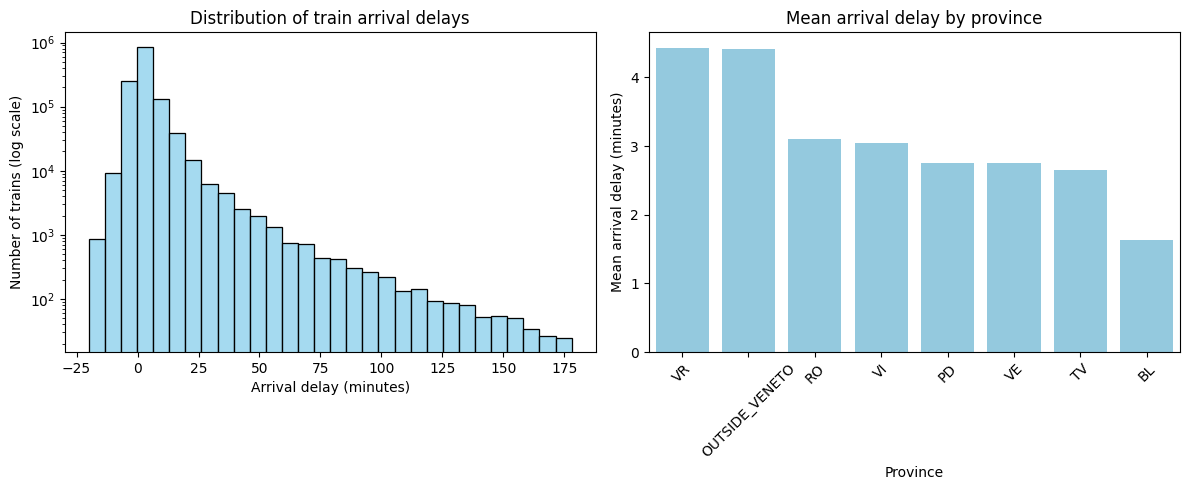

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of arrival delays
sns.histplot(trains_df['arrival_delay'].dropna(), bins=30, color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_yscale('log') # log scale to compensate for disparities
axes[0].set_xlabel("Arrival delay (minutes)")
axes[0].set_ylabel("Number of trains (log scale)")
axes[0].set_title("Distribution of train arrival delays")

# Mean arrival delay by province
province_stats = trains_df.groupby('province', observed=False)['arrival_delay'].mean().reset_index()
province_stats = province_stats.sort_values(by='arrival_delay', ascending=False)
sns.barplot(x='province', y='arrival_delay', data=province_stats, color='skyblue', ax=axes[1], order=province_stats['province'])
axes[1].set_ylabel("Mean arrival delay (minutes)")
axes[1].set_xlabel("Province")
axes[1].set_title("Mean arrival delay by province")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Distribución de retrasos en la llegada**

En el gráfico de la izquierda, utilizando una escala logarítmica en el eje y para que todas las barras sean visibles, podemos ver que la gran mayoría de los retrasos se concentran entre 0 y 5 minutos, mientras que los retrasos mayores disminuyen en frecuencia de manera gradual.

**Retraso medio en la llegada por provincia**

El gráfico de la derecha muestra el retraso medio en la llegada por provincia. BL (Belluno) tiene el menor retraso medio. La mayoría de las demás provincias presentan retrasos medios similares, ligeramente superiores a los de BL, mientras que VR (Verona) (junto con la categoría de provincias fuera del Véneto) exhiben los retrasos promedio más altos.

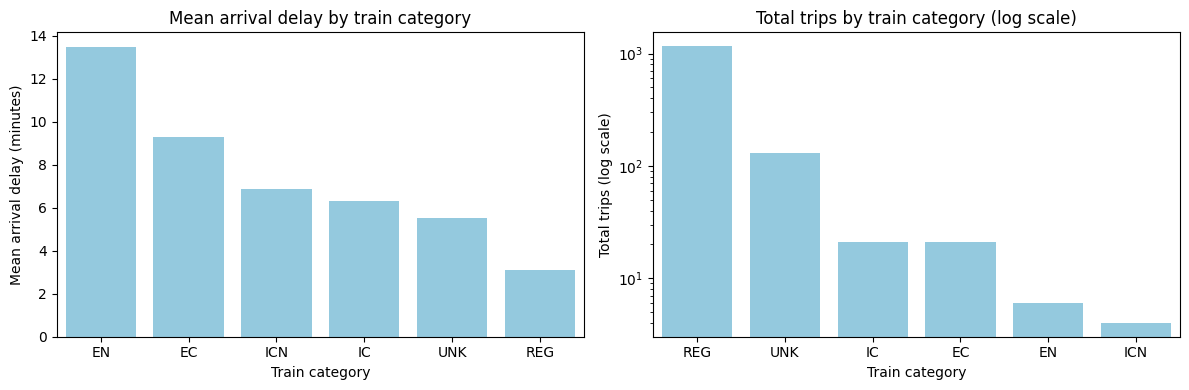

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Arrival delay by train category
category_stats = trains_df.groupby('category', observed=False)['arrival_delay'].mean().reset_index()
category_stats = category_stats.sort_values(by='arrival_delay', ascending=False)
sns.barplot(x='category', y='arrival_delay', data=category_stats, color='skyblue', ax=axes[0], order=category_stats['category'])
axes[0].set_ylabel("Mean arrival delay (minutes)")
axes[0].set_xlabel("Train category")
axes[0].set_title("Mean arrival delay by train category")

# Number of trains per category
total_trips_category = trains_df.groupby('category', observed=False)['train_number'].nunique().reset_index(name='total_trips')
total_trips_category = total_trips_category.sort_values(by='total_trips', ascending=False)
sns.barplot(x='category', y='total_trips', data=total_trips_category, color='skyblue', ax=axes[1], order=total_trips_category['category'])
axes[1].set_yscale('log')  # log scale to compensate for disparities
axes[1].set_ylabel("Total trips (log scale)")
axes[1].set_xlabel("Train category")
axes[1].set_title("Total trips by train category (log scale)")

plt.tight_layout()
plt.show()

**Retraso medio en la llegada por categoría de tren**

La primera tabla muestra el retraso medio en la llegada por categoría de tren. Podemos observar que los trenes EN y EC presentan los mayores retrasos en promedio. Los trenes REG, que representan la mayoría de los servicios, tienen los retrasos medios más bajos (≈ 3 minutos).

**Número total de viajes por categoría de tren**

La segunda tabla muestra el número total de viajes por categoría. Los trenes REG dominan el conjunto de datos. Esto resalta que, aunque algunas categorías presentan retrasos medios altos, ocurren con muy poca frecuencia, y la mayor parte del conjunto de datos está compuesta por trenes regionales con retrasos bajos.

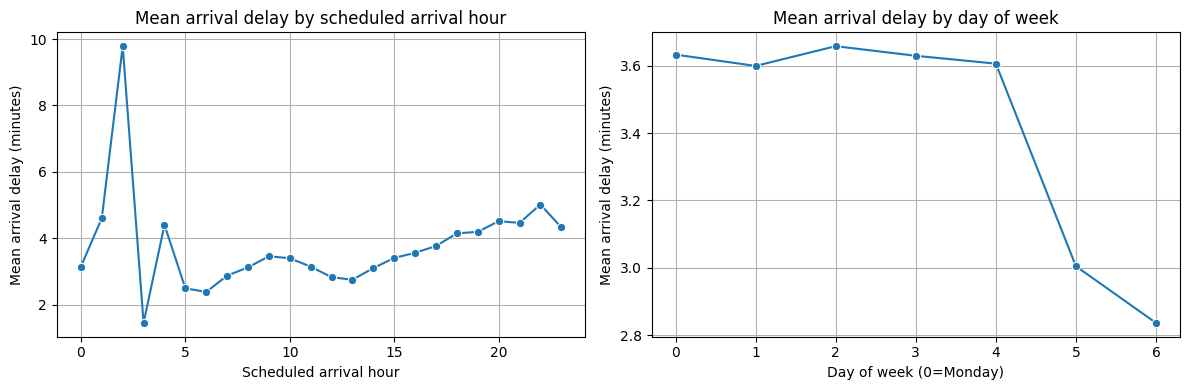

In [ ]:
# Mean arrival delay by scheduled hour
hour_stats = trains_df.groupby('scheduled_arrival_hour', observed=False)['arrival_delay'].mean()

# Mean arrival delay by day of week
dow_stats = trains_df.groupby('day_of_week', observed=False)['arrival_delay'].mean()

# Creating side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Mean delay by scheduled hour
sns.lineplot(x=hour_stats.index, y=hour_stats.values, marker='o', ax=axes[0])
axes[0].set_xlabel("Scheduled arrival hour")
axes[0].set_ylabel("Mean arrival delay (minutes)")
axes[0].set_title("Mean arrival delay by scheduled arrival hour")
axes[0].grid(True)

# Mean delay by day of week
sns.lineplot(x=dow_stats.index, y=dow_stats.values, marker='o', ax=axes[1])
axes[1].set_xlabel("Day of week (0=Monday)")
axes[1].set_ylabel("Mean arrival delay (minutes)")
axes[1].set_title("Mean arrival delay by day of week")
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Retraso medio en la llegada por hora de llegada programada**

Los datos muestran que los retrasos de los trenes varían a lo largo del día. Se observa un pico local notable en los retrasos medios durante las horas de la mañana (alrededor de las 8:00-11:00), seguido de una disminución hacia el mediodía y primeras horas de la tarde. Los retrasos vuelven a aumentar por la tarde y la noche (posiblemente coincidiendo con el tráfico de viajeros). Se observan retrasos mucho mayores muy tarde en la noche (tal vez debido a operaciones de mantenimiento en las líneas, o porque a esas horas no circulan trenes regionales y emergen los patrones de retraso de los trenes nocturnos).

**Retraso medio en la llegada por día de la semana**

Los retrasos también varían a lo largo de la semana. Los días laborables (de lunes a viernes) muestran retrasos medios similares de aproximadamente 3,6 minutos. Durante el fin de semana, los retrasos medios son menores, alrededor de 3 minutos el sábado y 2,8 minutos el domingo, reflejando menor tráfico y menos congestión. Los retrasos medios de lunes a viernes, en torno a los 3 minutos, están probablemente muy influenciados por los trenes regionales (REG), que constituyen la gran mayoría de los viajes en el conjunto de datos. Dado que los trenes REG tienen un retraso medio de aproximadamente 3 minutos, su predominio domina el cálculo de los promedios diarios.

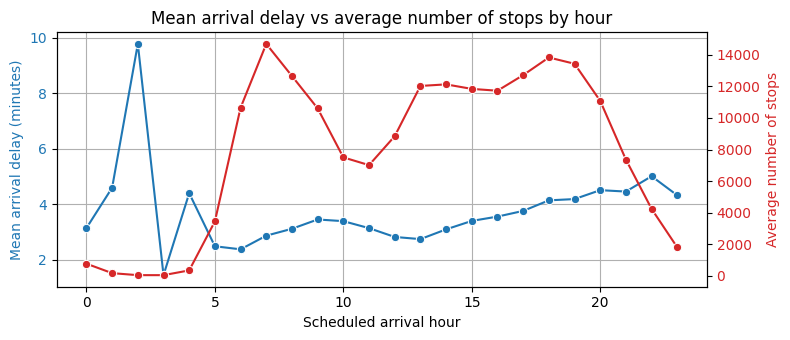

In [ ]:
# Calculating mean arrival delay by scheduled arrival hour
hour_delay = trains_df.groupby('scheduled_arrival_hour', observed=False)['arrival_delay'].mean()

# Calculating mean number of train stops by hour (average on all week)
hour_stops = (
    trains_df.groupby(['day_of_week', 'scheduled_arrival_hour'], observed=False)
    .size()
    .reset_index(name='num_stops')
)
mean_hour_stops = hour_stops.groupby('scheduled_arrival_hour')['num_stops'].mean()

# Creating plot
fig, ax1 = plt.subplots(figsize=(8,3.5))

# Average delay
color_delay = 'tab:blue'
ax1.set_xlabel('Scheduled arrival hour')
ax1.set_ylabel('Mean arrival delay (minutes)', color=color_delay)
sns.lineplot(x=hour_delay.index, y=hour_delay.values, marker='o', ax=ax1, color=color_delay)
ax1.tick_params(axis='y', labelcolor=color_delay)
ax1.grid(True)

# Average number of stops
ax2 = ax1.twinx()
color_stops = 'tab:red'
ax2.set_ylabel('Average number of stops', color=color_stops)
sns.lineplot(x=mean_hour_stops.index, y=mean_hour_stops.values, marker='o', ax=ax2, color=color_stops)
ax2.tick_params(axis='y', labelcolor=color_stops)

plt.title('Mean arrival delay vs average number of stops by hour')
fig.tight_layout()
plt.show()

**Retraso medio en la llegada vs número medio de paradas por hora**

La tabla muestra el retraso medio en la llegada junto con el número medio de paradas programadas por hora. Observamos que la tendencia de los retrasos promedio generalmente sigue, con un ligero desfase, la tendencia de las paradas programadas, confirmando la hipótesis de que los picos locales en los retrasos están en gran medida impulsados por la congestión de la red durante las horas punta. Los retrasos medios más altos observados en las horas de la noche no corresponden a picos en las paradas programadas, lo que indica que estos retrasos son causados por otros factores.

En general, este gráfico muestra que los efectos relacionados con la congestión son un contribuyente significativo a los picos localizados en los retrasos de los trenes.

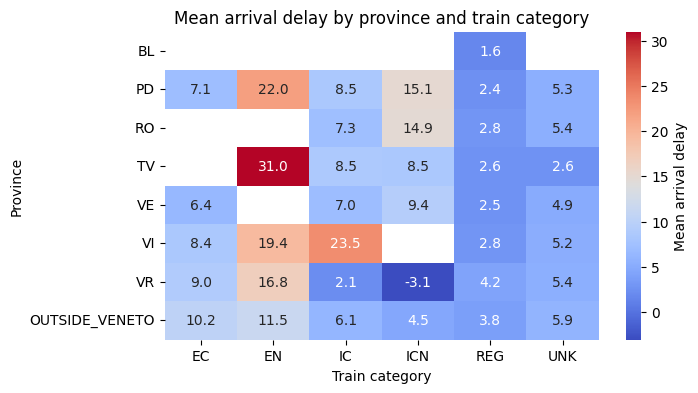

In [ ]:
# Mean delay for each province × category (category on x, province on y)
pivot_table = trains_df.pivot_table(index='province', columns='category', values='arrival_delay', aggfunc='mean', observed=False)

plt.figure(figsize=(7,4))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='coolwarm', cbar_kws={'label': 'Mean arrival delay'})
plt.title("Mean arrival delay by province and train category")
plt.ylabel("Province")
plt.xlabel("Train category")
plt.show()

**Retraso medio en la llegada por categoría de tren y provincia**

El mapa de calor muestra que los trenes regionales (REG) presentan retrasos bajos en todas las provincias, mientras que los trenes de larga distancia y exprés (EC, EN, ICN) tienden a tener retrasos mayores. Verona (VR) y las áreas fuera del Véneto muestran consistentemente retrasos más altos. Los mayores retrasos fuera del Véneto se deben probablemente, en parte, a que estas áreas tienen un número relativo mucho mayor de trenes no REG en el conjunto de datos, y los trenes no REG generalmente presentan retrasos medios más altos que los trenes REG. En general, tanto el tipo de tren como la ubicación influyen en los retrasos de llegada.

* * *

El Notebook 1b termina aquí. Ahora guardaré el dataframe trains_df como *trains_data_Veneto_1b.parquet*, para que pueda cargarse rápidamente en el Notebook 2 (**Tema 18: TFM - Parte II: Analítica Avanzada e Inteligencia Artificial**).

In [ ]:
trains_df.to_parquet("/content/drive/MyDrive/Trains_project/trains_data_Veneto_1b.parquet", index=False, engine='pyarrow')